In [18]:
import numpy as np
import torch
import torchvision.transforms as transforms
import pandas as pd
import os
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim
import time
import re
import pandas as pd
import torchvision.models as models
import torchmetrics

from io import StringIO
from PIL import Image
from torch import nn
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from transformers import AutoModel, BertModel, BertTokenizer, AutoTokenizer
from torchvision.models import resnet18, ResNet18_Weights

print(torch.__version__)

2.0.0+cu118


# AlexNet

In [3]:
class CustomImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, csv_file, transform=None, target_transform=None, test_file = False):
        self.root = root
        with open(csv_file) as file:
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
            self.df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
        self.transform = transform
        self.target_transform = target_transform
        self.num_classes = 19
        self.test_file = test_file

    def parse_labels(self, label_str):
        label_array = [0] * self.num_classes

        label_list = label_str.split()
        for label in label_list:
            index = int(label) - 1
            label_array[index] = 1

        return torch.tensor(label_array, dtype=torch.float)

    def __getitem__(self, index):
        img_path = os.path.join(self.root, self.df.iloc[index, 0])
        label_str = self.df.iloc[index, 1] 

        img = Image.open(img_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        if self.test_file:
            return img, self.df.iloc[index, 0]
        
        label = self.parse_labels(label_str)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label

    def __len__(self):
        return len(self.df)
    
root = "COMP5329S1A2Dataset/data"
train_csv_file = "COMP5329S1A2Dataset/train.csv"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

train_set = CustomImageFolder(root=root, csv_file=train_csv_file, transform=transform, test_file=False)

batch_size = 32

train_queue = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=False, num_workers=0
)

print(len(train_queue))

938


In [7]:
all_labels = torch.zeros_like(train_set[0][1])

for x, label in train_set:
    all_labels += label

In [8]:
proportion =  (all_labels / torch.sum(all_labels))
proportion = torch.where(proportion == 0, torch.tensor(1.0), proportion)

print(proportion)

if torch.cuda.is_available():
    proportion = proportion.to('cuda')

tensor([0.4899, 0.0250, 0.0938, 0.0273, 0.0243, 0.0300, 0.0262, 0.0475, 0.0224,
        0.0316, 0.0130, 1.0000, 0.0130, 0.0054, 0.0416, 0.0236, 0.0307, 0.0328,
        0.0219])


Sample 0
Image shape: torch.Size([3, 224, 224])
Label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


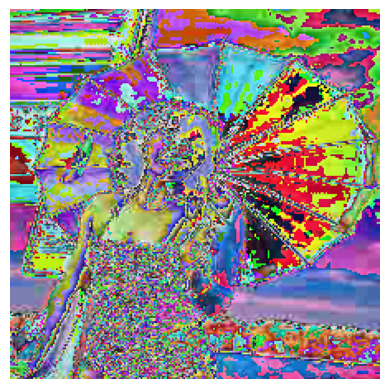

Sample 1
Image shape: torch.Size([3, 224, 224])
Label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.])


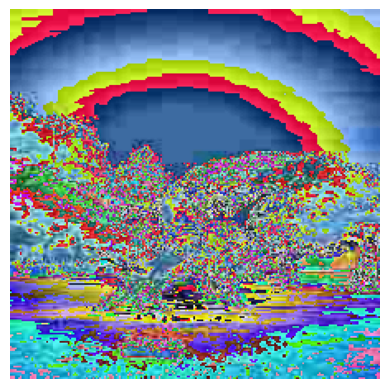

Sample 2
Image shape: torch.Size([3, 224, 224])
Label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


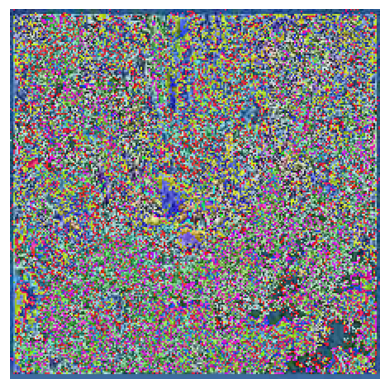

Sample 3
Image shape: torch.Size([3, 224, 224])
Label: tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.])


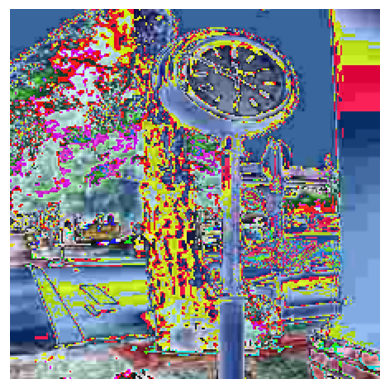

Sample 4
Image shape: torch.Size([3, 224, 224])
Label: tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


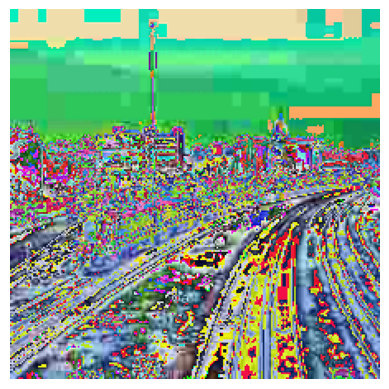

In [ ]:
for i in range(5):
    sample = train_set[i]
    print("Sample", i)
    print("Image shape:", sample[0].shape)
    print("Label:", sample[1])
    image = TF.to_pil_image(sample[0])
    plt.imshow(image)
    plt.axis('off') 
    plt.show()

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=18, stem_stride=4):
        # invoke super class initialisation method
        super(AlexNet, self).__init__()

        # define the CNN:
        # 1. define feature extraction layers
        self.features = nn.Sequential(
            # conv-relu-pooling
            nn.Conv2d(3, 64, kernel_size=11, stride=stem_stride, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv-relu-pooling
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv-relu-conv-relu-conv-relu-pooling
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # 2. define average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # 3. define fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),                   # use dropout
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),                   # use dropout
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        self.sigmoid = nn.Sigmoid()

    # define forward-propagation
    def forward(self, x):
        # feature extraction
        x = self.features(x)
        # adaptive pooling
        x = self.avgpool(x)
        # flat the feature map
        x = torch.flatten(x, start_dim=1)
        # classification
        x = self.classifier(x)
        x = self.sigmoid(x)

        return x

    # back-propagation is handled by PyTorch

In [ ]:
def multilabel_accuracy(output, target, threshold=0.5):

    pred = (output >= threshold).float()
    
    correct = (pred == target).float()
    batch_accuracy = correct.mean().item()
    
    return batch_accuracy

In [ ]:
model = AlexNet(num_classes=19, stem_stride=1)
learning_rate = 0.1
epochs = 10
threshold = 0.5

if torch.cuda.is_available():
    print('using GPU')
    model = model.to('cuda')
else:
    print('using CPU')

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

# define loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=proportion)

model.train()

print("=========== train start ===========")

for ep in range(epochs):
    start_time = time.time()
    correct_preds = 0
    total_samples = 0
    ep_loss = 0.0
    for step, (x, y) in enumerate(train_queue):
        if torch.cuda.is_available():
            x = x.to('cuda')
            y = y.to('cuda')
        # set gradient to zero
        optimizer.zero_grad()
        # calculate output
        p = model(x)
        # calculate metrics
        loss = criterion(p, y)
        acc = multilabel_accuracy(p, y, threshold)
        ep_loss += loss.item()
        # back-prop
        loss.backward()
        # update parameters
        optimizer.step()
        pred = (p >= threshold).float()
        correct_preds += (pred == y).sum().item()
        total_samples += y.numel()

        if step % 32 == 0:
            print('\repoch: %d step: %d loss: %.2f acc: %.4f'
                    % (ep, step, ep_loss/(step+1), correct_preds/total_samples), end='')
    end_time = time.time()
    print('\nepoch: %d loss: %.2f acc: %.4f Time: %.2f'
          % (ep, ep_loss/(step+1), correct_preds/total_samples, end_time - start_time))

In [ ]:
model_state_path = "model_weights.pth"
torch.save(model.state_dict(), model_state_path)

In [ ]:
model = AlexNet(num_classes=19, stem_stride=1)
model.load_state_dict(torch.load("model_weights.pth"))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
test_csv_file = "COMP5329S1A2Dataset/test.csv"

test_set = CustomImageFolder(root=root, csv_file=test_csv_file, transform=transform, test_file=True)

batch_size = 32

test_queue = torch.utils.data.DataLoader(
    test_set, batch_size=32, shuffle=False, num_workers=0
)

print(len(test_queue))

313


In [ ]:
model.eval()

pred_result = {}

with torch.no_grad():
    for x, indexs in test_queue:
        if torch.cuda.is_available():
            x = x.to('cuda')
        p = model(x)
        
        predictions = (p >= threshold).int()

        for i, index in enumerate(indexs):
            labels = predictions[i]
            num_labels = [idx + 1 for idx, value in enumerate(labels) if value != 0]
            pred_result[index] = num_labels

In [ ]:
rows = [{"ImageID": index, "Labels": ' '.join(map(str, labels))} for index, labels in pred_result.items()]
df = pd.DataFrame(rows)

output_csv_path = "cgan6985_jbai0252_zxia8013.csv"
df.to_csv(output_csv_path, index=False)

print(f"Predictions result saved to {output_csv_path}")

Predictions result saved to pred_result.csv


# Transformer(Res + Bert)

In [6]:
class TransformerDataLoader(torch.utils.data.Dataset):
    def __init__(self, root, csv_file, tokenizer, transform=None, target_transform=None, test_file = False):
        self.root = root
        with open(csv_file) as file:
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
            self.df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
        self.transform = transform
        self.target_transform = target_transform
        self.num_classes = 19
        self.test_file = test_file
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)
    
    def parse_labels(self, label_str):
        label_array = [0] * self.num_classes

        label_list = label_str.split()
        for label in label_list:
            index = int(label) - 1
            label_array[index] = 1

        return torch.tensor(label_array, dtype=torch.float)

    def __getitem__(self, index):
        img_path = os.path.join(self.root, self.df.iloc[index, 0])
        label_str = self.df.iloc[index, 1] 

        img = Image.open(img_path).convert('RGB')

        caption_loc = 2
        if self.test_file:
            caption_loc = 1

        text = self.df.iloc[index, caption_loc]
        text_data = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        input_ids = text_data['input_ids'].squeeze(0)
        attention_mask = text_data['attention_mask'].squeeze(0)

        if self.transform is not None:
            img = self.transform(img)
        
        if self.test_file:
            return img, input_ids, attention_mask, self.df.iloc[index, 0]
        
        label = self.parse_labels(label_str)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, input_ids, attention_mask, label
    
root = "COMP5329S1A2Dataset/data"
train_csv_file = "COMP5329S1A2Dataset/train.csv"

tokenizer = AutoTokenizer.from_pretrained('./bert-mini-finetuned-mnli/')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

data_set = TransformerDataLoader(root=root, csv_file=train_csv_file, tokenizer = tokenizer, transform=transform, test_file=False)

train_val_ratio = [int(len(data_set) * 0.9), len(data_set) - int(len(data_set) * 0.9)]

train_set, val_set = random_split(data_set, train_val_ratio)

print(len(data_set))

29996


Sample 0
Image shape: torch.Size([3, 224, 224])
Label: tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.])
input_ids: tensor([ 101, 1037, 3345, 2006, 3162, 2012, 3345, 2644, 2007, 2111, 2006, 1037,
        6847, 2648, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    

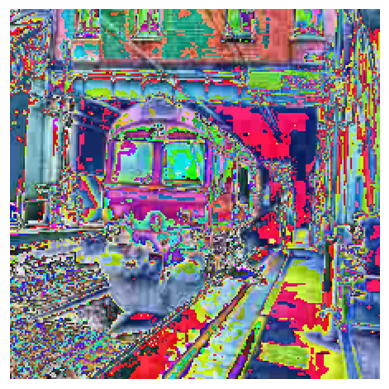

Sample 1
Image shape: torch.Size([3, 224, 224])
Label: tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.])
input_ids: tensor([  101,  2111,  3173,  3031, 12977,  2015,  2096,  3564,  2006, 19571,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     

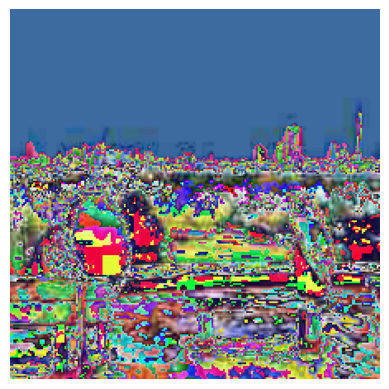

Sample 2
Image shape: torch.Size([3, 224, 224])
Label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])
input_ids: tensor([  101,  1037, 27747,  5559,  1037,  2312,  4400,  3504,  3805,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     

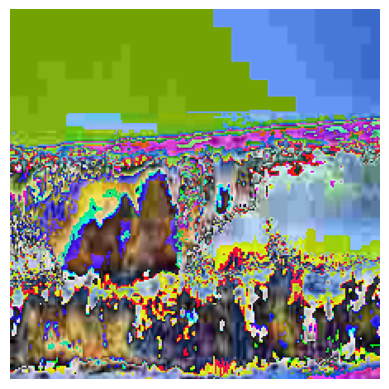

In [7]:
for i in range(3):
    sample = train_set[i]
    print("Sample", i)
    print("Image shape:", sample[0].shape)
    print("Label:", sample[3])
    print("input_ids:", sample[1])
    print("attention_mask:", sample[2])
    image = TF.to_pil_image(sample[0])
    plt.imshow(image)
    plt.axis('off') 
    plt.show()

In [8]:
class ResNet18BERTModel(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.1):
        super(ResNet18BERTModel, self).__init__()
        
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        num_resnet_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity() 
        
        self.bert = AutoModel.from_pretrained('./bert-mini-finetuned-mnli/')
        num_bert_features = self.bert.config.hidden_size
        
        combined_features = num_resnet_features + num_bert_features
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=combined_features, nhead=4)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_prob)

        self.classifier = nn.Linear(combined_features, num_classes)


    def forward(self, image, text_input_ids, text_attention_mask):
        image_features = self.resnet(image)

        text_output = self.bert(input_ids=text_input_ids, attention_mask=text_attention_mask)
        text_features = text_output.pooler_output
        
        # combine features from image and text
        combined_features = torch.cat((image_features, text_features), dim=1)

        transformer_output = self.transformer_encoder(combined_features.unsqueeze(0)).squeeze(0)
        
         # Apply dropout
        transformer_output = self.dropout(transformer_output)

        logits = self.classifier(transformer_output)

        return logits

In [9]:
def train_validation_model(epochs, learning_rate, batch_size, optimizer_type):
    
    threshold = 0.5
    
    transfom_model = ResNet18BERTModel(num_classes=19)
    
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(transfom_model.parameters(), lr=learning_rate)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(transfom_model.parameters(), lr=learning_rate)
        
    train_queue = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=False, num_workers=0
    ) 

    val_queue = DataLoader(
        val_set, batch_size=batch_size, shuffle=False, num_workers=0
    )
    
    optimizer = torch.optim.Adam(transfom_model.parameters(), lr=learning_rate)
    criterion =nn.BCEWithLogitsLoss()
    f1_score = torchmetrics.F1Score(num_labels=19, task='multilabel')
    f1_score_val = torchmetrics.F1Score(num_labels=19, task='multilabel')

    if torch.cuda.is_available():
        print('using GPU')
        transfom_model = transfom_model.to('cuda')
        f1_score = f1_score.to('cuda')
        f1_score_val = f1_score_val.to('cuda')
    else:
        print('using CPU')

    val_metrics = []

    for ep in range(epochs):
        start_time = time.time()
        correct_preds = 0
        total_samples = 0
        ep_loss = 0.0
        transfom_model.train()
        for step, (images, input_ids, attention_masks, labels) in enumerate(train_queue):
            if torch.cuda.is_available():
                images = images.to('cuda')
                input_ids = input_ids.to('cuda')
                attention_masks = attention_masks.to('cuda')
                labels = labels.to('cuda')
            # set gradient to zero
            optimizer.zero_grad()
            # train
            output = transfom_model(images, input_ids, attention_masks)
            # get loss
            loss = criterion(output, labels)
            # back propogation
            loss.backward()
            optimizer.step()

            # cal f1_score
            probs = torch.sigmoid(output)
            f1_score.update(probs, labels.int())
            ep_loss += loss.item()

            if step % 100 == 0:
                current_f1_score = f1_score.compute().mean()
                print(f'\rEpoch: {ep}, Step: {step}, Loss: {ep_loss/(step+1):.2f}, F1-Score: {current_f1_score:.4f}', end='')
                f1_score.reset()    

        transfom_model.eval()
        val_loss = 0.0
        f1_score_val.reset()
        # validation process
        with torch.no_grad():  # Disable gradients for validation
            for val_step, (val_images, val_input_ids, val_attention_masks, val_labels) in enumerate(val_queue):
                if torch.cuda.is_available():
                    val_images = val_images.to('cuda')
                    val_input_ids = val_input_ids.to('cuda')
                    val_attention_masks = val_attention_masks.to('cuda')
                    val_labels = val_labels.to('cuda')

                val_output = transfom_model(val_images, val_input_ids, val_attention_masks)
                val_loss_batch = criterion(val_output, val_labels)
                val_loss += val_loss_batch.item()

                val_probs = torch.sigmoid(val_output)
                f1_score_val.update(val_probs, val_labels.int())
        val_metrics.append(f1_score_val.compute().mean())
        val_loss_avg = val_loss / len(val_queue)
        end_time = time.time()

        current_f1_score = f1_score.compute().mean()
        print(f'\nEpoch: {ep} end, Train_Loss: {ep_loss/(step+1):.2f}, Val Loss: {val_loss_avg:.2f}, Train F1-score:{current_f1_score:.4f} , Val F1-Score: {val_metrics[ep]:.4f}, Epoch Training time:{end_time - start_time:.2f}')
    return transfom_model, val_metrics

In [11]:
epochs = 5
learning_rates = [0.0001, 0.00005, 0.00001]
batch_sizes = [8, 16, 32]
optimzers = ['Adam', 'SGD']

best_model = None
best_params = ''
best_val_metrics = -1
params = {}
for lr in learning_rates:
    for bs in batch_sizes:
        for optimzer in optimzers:
            print(f"lr: {lr}, batch_size: {bs}, optimzers: {optimzer} start")
            model, val_metrics = train_validation_model(epochs, lr, bs, optimzer)
            key = (lr, bs, optimzer)
            params[key] = val_metrics
            max_val = max(val_metrics)
            if max_val > best_val_metrics:
                best_model = model
                best_params = key
                best_val_metrics = max_val

lr: 0.0001, batch_size: 8, optimzers: Adam start
using GPU
Epoch: 0, Step: 3300, Loss: 0.10, F1-Score: 0.8085
Epoch: 0 end, Train_Loss: 0.10, Val Loss: 0.08, Train F1-score:0.7961 , Val F1-Score: 0.8232, Epoch Training time:123.92
Epoch: 1, Step: 3300, Loss: 0.08, F1-Score: 0.8351
Epoch: 1 end, Train_Loss: 0.08, Val Loss: 0.08, Train F1-score:0.8265 , Val F1-Score: 0.8310, Epoch Training time:122.89
Epoch: 2, Step: 3300, Loss: 0.06, F1-Score: 0.8515
Epoch: 2 end, Train_Loss: 0.06, Val Loss: 0.08, Train F1-score:0.8447 , Val F1-Score: 0.8316, Epoch Training time:123.01
Epoch: 3, Step: 3300, Loss: 0.05, F1-Score: 0.8696
Epoch: 3 end, Train_Loss: 0.05, Val Loss: 0.08, Train F1-score:0.8745 , Val F1-Score: 0.8256, Epoch Training time:124.85
Epoch: 4, Step: 3300, Loss: 0.04, F1-Score: 0.8965
Epoch: 4 end, Train_Loss: 0.04, Val Loss: 0.09, Train F1-score:0.8851 , Val F1-Score: 0.8289, Epoch Training time:122.34
lr: 0.0001, batch_size: 8, optimzers: SGD start
using GPU
Epoch: 0, Step: 3300, L

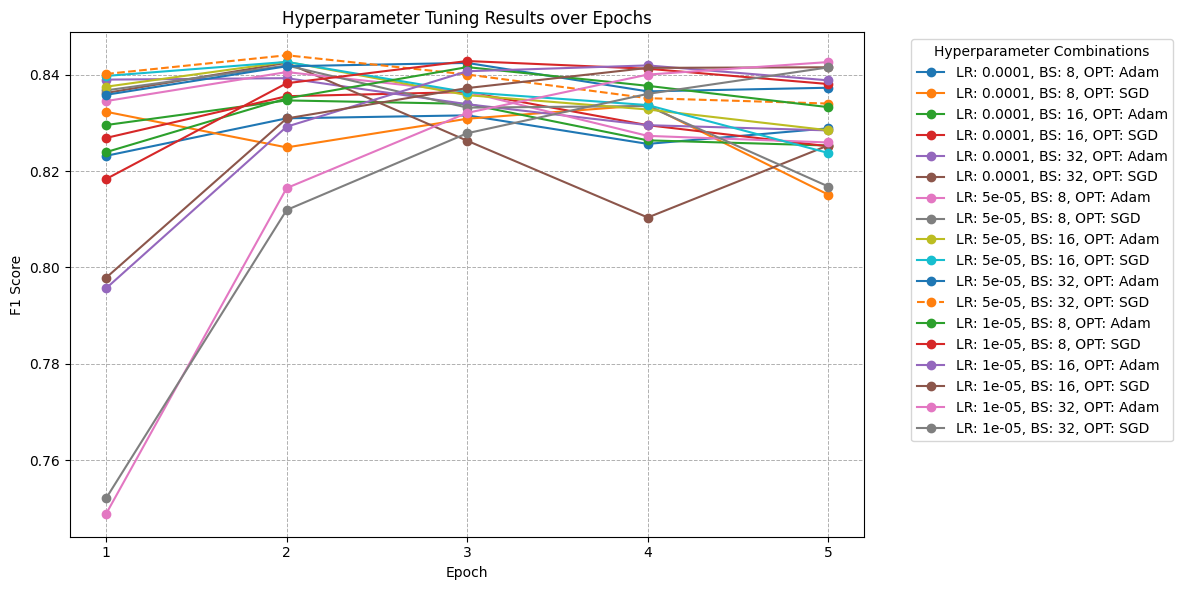

In [36]:
plt.figure(figsize=(12, 6))

for key, metrics in params.items():
    lr, bs, optimizer = key
    label = f"LR: {lr}, BS: {bs}, OPT: {optimizer}"
    linestyle = '-'
    if key == best_params：
        linestyle = '--'
        label = label + '(best)'
    epochs = list(range(1, len(metrics) + 1))
    plt.plot(epochs, [m.cpu().item() if isinstance(m, torch.Tensor) else m for m in metrics], label=label, linestyle=linestyle, marker='o')
    
plt.xticks(range(1, max(epochs) + 1))
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Hyperparameter Tuning Results over Epochs')
plt.legend(title='Hyperparameter Combinations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

In [35]:
best_model, metrics = train_validation_model(8, 0.00001, 32, 'Adam')

/root/miniconda3/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


using GPU
Epoch: 0, Step: 800, Loss: 0.16, F1-Score: 0.7303
Epoch: 0 end, Train_Loss: 0.16, Val Loss: 0.10, Train F1-score:0.7282 , Val F1-Score: 0.7585, Epoch Training time:75.82
Epoch: 1, Step: 800, Loss: 0.10, F1-Score: 0.8091
Epoch: 1 end, Train_Loss: 0.10, Val Loss: 0.08, Train F1-score:0.7987 , Val F1-Score: 0.8152, Epoch Training time:76.59
Epoch: 2, Step: 800, Loss: 0.08, F1-Score: 0.8390
Epoch: 2 end, Train_Loss: 0.08, Val Loss: 0.08, Train F1-score:0.8316 , Val F1-Score: 0.8348, Epoch Training time:76.42
Epoch: 3, Step: 800, Loss: 0.07, F1-Score: 0.8561
Epoch: 3 end, Train_Loss: 0.07, Val Loss: 0.07, Train F1-score:0.8508 , Val F1-Score: 0.8393, Epoch Training time:76.15
Epoch: 4, Step: 800, Loss: 0.06, F1-Score: 0.8751
Epoch: 4 end, Train_Loss: 0.06, Val Loss: 0.07, Train F1-score:0.8691 , Val F1-Score: 0.8399, Epoch Training time:76.26
Epoch: 5, Step: 800, Loss: 0.05, F1-Score: 0.8890
Epoch: 5 end, Train_Loss: 0.06, Val Loss: 0.07, Train F1-score:0.8798 , Val F1-Score: 0.83

In [12]:
model.eval()
model.half()
model_state_path = "tran_model_weights.pth"
torch.save(model.state_dict(), model_state_path)

In [13]:
model = ResNet18BERTModel(num_classes=19)
model.load_state_dict(torch.load("tran_model_weights.pth"))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet18BERTModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [14]:
test_csv_file = "COMP5329S1A2Dataset/test.csv"

test_set = TransformerDataLoader(root=root, csv_file=test_csv_file, tokenizer = tokenizer, transform=transform, test_file=True)

batch_size = 32

test_queue = torch.utils.data.DataLoader(
    test_set, batch_size=32, shuffle=False, num_workers=0
)

print(len(test_queue))

313


In [16]:
model.eval()

pred_result = {}

with torch.no_grad():
    for img, input_ids, attention_mask, indexs  in test_queue:
        if torch.cuda.is_available():
            img = img.to('cuda')
            input_ids = input_ids.to('cuda')
            attention_mask = attention_mask.to('cuda')
        output = model(img, input_ids, attention_mask)
        p = torch.sigmoid(output)
        predictions = (p >= 0.5).int()

        for i, index in enumerate(indexs):
            labels = predictions[i]
            num_labels = [idx + 1 for idx, value in enumerate(labels) if value != 0]
            pred_result[index] = num_labels

In [17]:
rows = [{"ImageID": index, "Labels": ' '.join(map(str, labels))} for index, labels in pred_result.items()]
df = pd.DataFrame(rows)

output_csv_path = "cgan6985_jbai0252_zxia8013.csv"
df.to_csv(output_csv_path, index=False)

print(f"Predictions result saved to {output_csv_path}")

Predictions result saved to cgan6985_jbai0252_zxia8013.csv
